In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import factorial
from scipy.linalg import norm
from sympy.plotting import plot as spPlot
import matplotlib.pyplot as plt
import random as rd
from scipy.sparse import *
from scipy.sparse.linalg import *
from scipy.optimize import linprog
#from ortools.linear_solver import pywraplp
#import pulp
#from pulp import LpMaximize, LpProblem, LpStatus, lpSum, LpVariable, COIN_CMD
import cplex
#drive.mount('/content/drive')
from docplex.mp.model import Model
from gurobipy import *
from itertools import product
from scipy.linalg import block_diag

# Introduction

## Modeling of the problem as a two-stage stochastic program


There are two shifts for operators working at a warehouse. Each of the $y^i_1$ operators working at the morning shift on the $i$th day of the month, is required to pick at least 5 orders. Besides, all of the $D^i_3$ orders of the third type are meant to be picked in this first shift.  Each of the $y^i_2$ operators working at the morning shift on the $i$th day of the month, is required to pick at least 5 orders. They are also asked to picked all of the $D^i_1$ orders of the first type. The orders of the second type can be picked in either of both shifts. An additional constraint of the problem is that in the first day of the month the maximum available number of operators has to be decided.  Translating this into equations turns out in

\begin{align}
5y^i_1\geq D^i_3+D^i_2 & &\forall 1\leq i \leq 30\\ 
5y^i_2\geq D^i_1 &  & \forall 1\leq i \leq 30  \\
y^i_1+y^i_2\leq y_1^1+y_2^1 & & \forall 2\leq i \leq 30 
\end{align}

The reason why we assume all orders of the second type will be placed in the morning  is to get as much work done ahead of schedule as possible. We will also ask the cost to be bellow a maximum cost parameter:

$$ c^T y^1 \leq c_{max}$$

where $c$ is the vector of hiring costs. If $q^i$ is vector of operation costs per operator on day $i$, the previous problem can be formulated through a two-stage stochastic program as

\begin{align}
  \min & & c^T y^1 +E\left[ \min\left\{  \sum_{i=2}^{30} (y^i)^Tq^i \right\}\right]\\
  \text{s.a.} &  & c^T y^1 \leq    c_{max} \\
              &  & 5y^i_1\geq D^i_3+D^i_2 \quad\forall 1\leq i \leq 30 \\
              &  & 5y^i_2\geq D^i_1\quad \forall 1\leq i \leq 30 \\
              &  & y^i_1+y^i_2\leq y_1^1+y_2^1 \quad \forall 2\leq i \leq 30\\
               & & y^i \geq 0 \forall 1\leq i \leq 30 \\
\end{align}


We want to use  L-Shaped algorithm to solve the previous problem, therefore it is necessary to write it in its standard form. To that end we introduce the following notation

Let $ T_1\in \mathbb{R}^{90\times 2}$ be the matrix  given by 

$$T_1:=\begin{pmatrix} 5&5 \\ 0&0 \\ 0&0 \\\hline \\ 0 & 0 \\ 0 & 0 \\ 1 & 1 \\ \vdots \\  0 & 0 \\ 0 & 0 \\ 1 & 1   \end{pmatrix} $$

The reason why $T_1$ has 90 rows is because there are 3 constraints for each of the 29 $y^i$. 

Let $y \in \mathbb{R}^{58}$ be the vector resulting from concatenating all of the $y^i$ with  $i\geq 2$ i.e.

$$y:=\begin{pmatrix}  y^2_1 \\   y^2_2 \\ \vdots \\ y^{30}_1 \\ y^{30}_2   \end{pmatrix} $$




Consider $W_0\in \mathbb{R}^{3 \times 2}$  the matrix given by 
$$ W_0:= \begin{pmatrix}  5 & 0 \\ 0 & 5 \\ -1 & -1    \end{pmatrix}$$

and let $ W_1 \in \mathbb{R}^{90\times 58}$ be the block matrix induced by $W_0$:

$$ W_1:= \begin{pmatrix} O_{3\times 2} & O_{3\times 2} & \cdots & O_{3\times 2}  \\ W_0 & 0 & \cdots  & 0 \\  0 & W_0 & \cdots  & 0 \\ \vdots \\ 0 & 0 & \cdots  & W_0  \end{pmatrix}$$.

Finally, the last variable to be introduced is  $h \in \mathbb{R}^{90 \times 1}$ given by 



$$ h:= \begin{pmatrix} D^1_2+D^1_3 \\ D^1_1 \\ 0 \\  \vdots \\ D^{30}_2+D^{30}_3 \\ D^{30}_1\\0\end{pmatrix}$$





With this notation we can re write the stochastic program as

\begin{align}
  \min & & c^T y^1 +E\left[ \min\{q^Ty \}\right]\\
  \text{s.a.} &  & T_1y^1+W_1 y \geq   h \\
              & & y^1 \geq 0, \hat{y}\geq 0
\end{align}


The final step to turn our problem into a standard form problem is to turn the inequality $T_1y^1+W_1 y \geq   h$ into an equality. To that end we use a slack variable $s\in \mathbb{R}^{90\times 1}$ and rewrite our problem as 

\begin{align}
  \min & & c^T y^1 +E\left[ \min\{q^Ty \}\right]\\
  \text{s.a.} &  & T_1y^1+W_1 y +s= h \\
              & & y^1 \geq 0,y\geq 0,s\geq 0
\end{align}


And leting  $\hat{y} $ be $\hat{y}:=\begin{pmatrix} y \\ \hline  s \end{pmatrix} \in \mathbb{R}^{148}$ and

$$  W:= \left( \begin{array}{c|c}  W_1   &I_{87\times 87}  \end{array} \right) \in \mathbb{R}^{87\times 148} $$

we obtain

\begin{align}
  \min & & c^T y^1 +E\left[ \min\{q^Ty \}\right]\\
  \text{s.a.} &  & T_1y^1+W\widehat{y}= h \\
              & & y^1 \geq 0, \hat{y}\geq 0\end{align}

As said, we wish to have a maximum cost restriction. Let us append a last restricition on the problem above

\begin{align}
  \min & & c^T y^1 +E\left[ \min\{q^Ty \}\right]\\
  \text{s.a.} &  & A x=c_{max} \\
              &  & Tx+W\widehat{y}= h \\
              & & x \geq 0, \hat{y}\geq 0
\end{align}

where $A=\begin{pmatrix} y^1 \\ \hline 1 \end{pmatrix}\in  \mathbb{R}^3$, $c_{max}\in \mathbb{R}$ is a parameter of the problem, $T$ is equal to $T_1$ but with a column of zeros at the end and $x:=\begin{pmatrix} y^1 \\ \hline  s^1 \end{pmatrix} \in \mathbb{R}^{3}$. Here $ s^1$ is also a slack variable. We finally have the problem modeled an writen as a standard stochastic program of two stages in its standard form

# Estimated distribution of the demand variables

Since the only random parameter of the linear program is

$$ h:= \begin{pmatrix} D^1_2+D^1_3 \\ D^1_1 \\ 0 \\  \vdots \\ D^{30}_2+D^{30}_3 \\ D^{30}_1\\0\end{pmatrix}$$

we need to estimate the distribution of $Z^i:=D^i_2+D^i_3 $ and $D^2_1$ for each $i$ in order to take the average of the Bender's cuts in the $L-$shaped algorithm.

In order to take into account the CovidAfectedness we will choose a discount tunable parameter $\lambda\in (0,1)$ and 
make the following estimation:

Let $ S_1^i$ be $S_1^i=\sum_{k\in \mathbb{N}}\sum_{i=0}^3 \#(D_1^i=k\text{ and } Aff=i) \lambda^i$ so for each $k$
the probability of $D_1^i$ taking a value $k$ will be estimated by
$$ p_{k}^i:=\frac{\sum_{i=0}^3 \#(D_1^i=k\text{ and } Aff=i) \lambda^i}{S_1^i} $$

Similarly, let $ S_2^i$ be $S_2^i=\sum_{k\in \mathbb{N}}\sum_{i=0}^3 \#(Z^i=k\text{ and } Aff=i) \lambda^i$ so for each $k$
the probability of $D_1^i$ taking a value $k$ will be estimated by
$$ q_{k}^i:=\frac{\sum_{i=0}^3 \#(Z^i=k\text{ and } Aff=i)   \lambda^i}{S_1^i} $$



Here $Aff $ is the level of afectedness and $ \#(X=k\text{ and } Aff=i)$ is the number of times $ X$ was $ k$ and the level of afectedness was $i$ in the data set

In [2]:
lmbda=0.5

In [3]:
#datos
datos=pd.read_csv('Datos_Prueba_DataScientist.csv').astype({'RequestTime':'datetime64[ns]'})
#Número de ventas diarias
datos['RequestTime']=datos['RequestTime'].dt.date
ventasDiaDia=datos.groupby(['RequestTime','DeliveryOption']).agg(k=('OrderId','nunique')).reset_index()
ventasDiaDia['DeliveryOption']= ventasDiaDia['DeliveryOption'].map({'Mismo dia entre 6:30 pm y 8:30 pm':'D1',
       'Siguiente dia entre 12:30 pm y 2:30 pm':'Z',
       'Siguiente dia entre las 6:30 pm y 8:30 pm':'Z'})
#Afectacion
afectacionCovid=pd.date_range(start='2018-01', end='2021-03', freq='M').to_series().dt.to_period('M').to_frame().rename(columns={0:'mes'}).reset_index(drop=True)
dictAfectedness=dict(zip(afectacionCovid[afectacionCovid['mes']>='2020-03']['mes'],[3,3,1,1,1,2,2,1,1,2,2,1]))
afectacionCovid['afectacion']=np.where(afectacionCovid['mes']<'2020-03',0,afectacionCovid['mes'].map(dictAfectedness))
dictAfectedness2=dict(zip(afectacionCovid['mes'], afectacionCovid['afectacion']))
ventasDiaDia['mes']=ventasDiaDia['RequestTime'].astype('datetime64[ns]').dt.to_period('M')
ventasDiaDia['dia']=ventasDiaDia['RequestTime'].astype('datetime64[ns]').dt.day
ventasDiaDia['aff']=ventasDiaDia['mes'].map(dictAfectedness2).astype('int64')

In [4]:
aa=ventasDiaDia.groupby(['DeliveryOption','dia','k','aff']).size().to_frame().reset_index()


In [5]:
D_1={i:{} for i in range(1,31)}
Z={i:{} for i in range(1,31)}


In [6]:
for i in D_1.keys():
    diccionario={}
    temp=aa[(aa['DeliveryOption']=='D1')&(aa['dia']==i)]
    
    for k in temp['k'].unique():
        temp_k=temp[temp['k']==k]
        diccionario[k]=sum([float(temp_k[temp_k['aff']==i][0]*lmbda**i) if temp_k[temp_k['aff']==i].shape[0]>0 else 0    for i in range(4)])
    diccionario2={}
    S=sum(diccionario.values())
    for k in diccionario.keys():
        diccionario2[k]=diccionario[k]/S
    D_1[i]=diccionario2
    

                        
                        
                        
                        
                        
                        

In [7]:
for i in Z.keys():
    diccionario={}
    temp=aa[(aa['DeliveryOption']=='Z')&(aa['dia']==i)]
    
    for k in temp['k'].unique():
        temp_k=temp[temp['k']==k]
        diccionario[k]=sum([float(temp_k[temp_k['aff']==i][0]*lmbda**i) if temp_k[temp_k['aff']==i].shape[0]>0 else 0    for i in range(4)])
    diccionario2={}
    S=sum(diccionario.values())
    for k in diccionario.keys():
        diccionario2[k]=diccionario[k]/S
    Z[i]=diccionario2

In [8]:
def roll(DicDistribucion):
    massDist=list(DicDistribucion.values())
    randRoll = rd.random() # uniforme en [0,1]
    n=len(massDist)
    cotas=[kk for kk in range(n) if randRoll>=sum(massDist[0:kk])]
    return list(DicDistribucion.keys())[int(max(cotas))]    






Visualization of the distributions of some of the random variables involved in the process

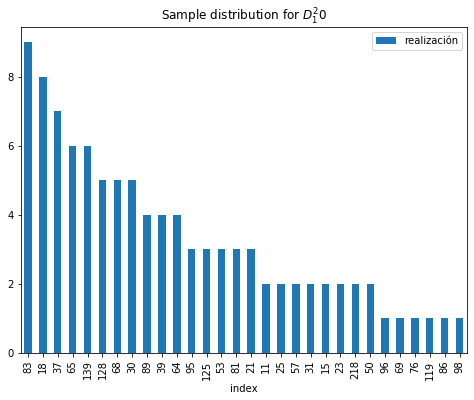

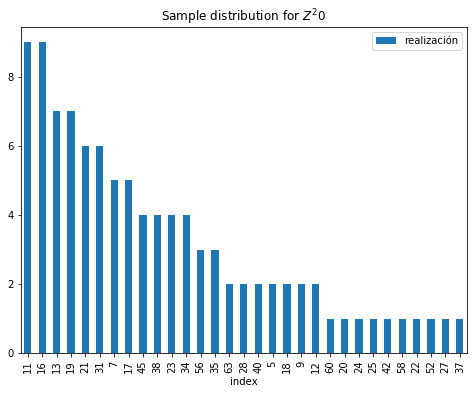

In [9]:
i=np.random.randint(1,31)

#D_1
sample=[roll(D_1[i]) for j in range(100)]
fig,ax=plt.subplots(figsize=(8,6))
ax.set_title('Sample distribution for '+r'$D_1^{i}$'.format(i=i))
pd.DataFrame(pd.DataFrame(sample).astype(str).rename(columns={0:'realización'})['realización'].value_counts()).reset_index().astype({'index':'int64'}).plot(kind='bar',y='realización',x='index',ax=ax)

#Z

sample=[roll(Z[i]) for j in range(100)]
fig,ax2=plt.subplots(figsize=(8,6))
ax2.set_title('Sample distribution for '+r'$Z^{i}$'.format(i=i))
pd.DataFrame(pd.DataFrame(sample).astype(str).rename(columns={0:'realización'})['realización'].value_counts()).reset_index().astype({'index':'int64'}).plot(kind='bar',y='realización',x='index',ax=ax2)


# Code and numeric results

In [10]:
#Global parameters of the problem
workRate=10
T=np.array([[1,0],[0,1],[0,0]]+[[0,0],[0,0],[1,1]]*29).reshape(90,2)
W0=np.array([[workRate,0],[0,workRate],[-1,-1]])
W1=np.vstack([ np.zeros((3,58))  ,block_diag(*[W0]*29)])
W=np.block([W1,-np.eye(90)])

In [11]:
T.shape, W.shape, W1.shape

((90, 2), (90, 148), (90, 58))

The operation and hiring costs $c$ and $q$ are parameters of the problem. We will set whatever value at first

In [12]:
q=np.array([2,2]*29+[0]*90)
c=np.array([10,10])
c_MAX=(10**6)*sum(c.tolist())
A=np.array(c.tolist()+[1]).reshape(-1,1)

In order to implement $L-$shaped algorithm it is necessary to enumerate all the possible realization of the random variables of the problem. Unfortunately, the number of possible realizations for the variable $h$ exceeds what this machine can handle.So, to keep the computability of this problem in reasonable levels, we will assumme that all of the $D^i$ assume the same value at the same time. Also, it will be assumed that  all of the $Z^i$ take the same value at the same time. 

In [13]:
big=np.prod([len(D_1[i].keys()) for i in D_1.keys()])*np.prod([len(Z[i].keys()) for i in Z.keys()])

'The number of realizations of h without the naive assumption would be {big}'.format(big=big)

/Users/nicolasbetancourt/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in long_scalars
  """Entry point for launching an IPython kernel.


'The number of realizations of h without the naive assumption would be -6341068275337658368'

In [14]:
idx_Z=[i for i in Z.keys() if len(Z[i].keys())== max([len(Z[i].keys()) for i in Z.keys()])][0]
idx_D=[i for i in D_1.keys() if len(D_1[i].keys())== max([len(D_1[i].keys()) for i in Z.keys()])][0]

In [15]:
Ztemp=Z[idx_Z]
Dtemp=D_1[idx_D]
small=len(Ztemp.keys())*len(Dtemp.keys())
'The number of realizations of h assuming what we said is  {small}'.format(small=small)

'The number of realizations of h assuming what we said is  1776'

In [16]:
realizaciones=list(product(Ztemp.keys(),Dtemp.keys()))

For sake of simplicity we will assume that random variables corresponding to different types of order and to different days of the nonth are independent.

In [17]:
probas={(z,d): Ztemp[z]*Dtemp[d]  for z,d in realizaciones}




### $L$-shaped

In [18]:
#Inicializo el maestro sin cortes de ningún tipo
maestro=Model('maestro')
maestro.setParam("OutputFlag",0)
maestro.setParam("InfUnbdInfo", 1)
s1=maestro.addMVar(shape=1,lb=0,name='s1',vtype = GRB.CONTINUOUS,)
y1=maestro.addMVar(shape=2,lb=0 ,name='y^1',vtype = GRB.CONTINUOUS,)
theta=maestro.addMVar(shape=1,lb=0,name='theta',vtype = GRB.CONTINUOUS,)
maestro.setObjective(c@y1+theta,GRB.MINIMIZE)
#maestro.addConstr(c@y1+s1==c_MAX)
maestro.optimize()
y1_temp=np.array([y1[0].x,y1[1].x]).reshape(-1,)
s1_temp=s1.x
theta_temp=-np.inf


Academic license - for non-commercial use only - expires 2021-07-08
Using license file /Users/nicolasbetancourt/gurobi.lic


In [19]:
NoParar=True
j=0
while NoParar:
    pis={}
    if j%10==0 and j>20:
        print(j)
    for i,escenario in enumerate(realizaciones):
        print('saludos')
        if i%5000==0 and i>0:
            print('i',i)
        z,d=escenario
        esclavo=Model('esclavo_'+str(i))
        esclavo.setParam("OutputFlag",0)
        esclavo.setParam("InfUnbdInfo", 1)
        
        
        
        y_gorro=esclavo.addMVar(shape=148,lb=0,name='y',vtype = GRB.CONTINUOUS,)
        esclavo.setObjective(q@y_gorro,GRB.MINIMIZE)
        
        h=np.array([z,d,0]*30)
        
        restr=esclavo.addConstr(W@y_gorro==h-T@y1_temp)
        esclavo.optimize()
        
        if esclavo.status == GRB.Status.INFEASIBLE:
            print('infeasible :(')
            #certificado de infactibilidad
            sigma=restr.getAttr("FarkasDual")
            maestro.addConstr((sigma.T@T)@y1>=sigma.T@h)
            maestro.optimize()
            y1_temp=np.array([y1[0].x,y1[1].x]).reshape(-1,)
            break
        else:
            
            esclavo_dual=Model('esclavo_dual_'+str(i))
            esclavo_dual.setParam("OutputFlag",0)
            pi=esclavo_dual.addMVar(shape=90,name='pi')
            esclavo_dual.setObjective((h-T@y1_temp).T@pi,GRB.MAXIMIZE)
            esclavo_dual.addConstr(W.T@pi<=q)
            esclavo_dual.optimize()
            pi_temp=np.array([float(pi[i].x) for i in range(pi.shape[0])])
            pis[escenario]=pi_temp
            
    #Si llegó hasta acá es porque todos los esclavos fueron factibles
    E=sum([probas[escenario]*pis[escenario].T@T for escenario in realizaciones])
    e=sum([probas[escenario]*pis[escenario].T@h for escenario in realizaciones])
    if e-E@y1_temp<=theta_temp:
        print('Convergió')
        NoParar=False
    else:
        maestro.addConstr(E@y1+theta>=e)
        maestro.optimize()
        y1_temp=np.array([y1[0].x,y1[1].x]).reshape(-1,)
        theta_temp=theta[0].x
    j=j+1
   
        

       

saludos
infeasible :(


KeyError: (4, 7)

In [ ]:
W.shape

# Alternative code for $L$-shaped


In [20]:
def feasibility_cut(y1_temp):
    
    xv = y1_temp
    D = np.zeros(3)
    d = 0
    
    feasCUT = 0
    feasCUT = 0
    for i,escenario in enumerate(realizaciones):
        z,d=escenario
        problema_feasibility = Model("feasibility")
        problema_feasibility.setParam('OutputFlag', 0)
        
        
        y = problema_feasibility.addMVar(shape=148, lb=0.0, vtype = GRB.CONTINUOUS, name='y')
        vmas = problema_feasibility.addMVar(shape=90, lb=0.0, vtype = GRB.CONTINUOUS, name='v+')
        vmenos = problema_feasibility.addMVar(shape=90, lb=0.0, vtype = GRB.CONTINUOUS, name='v-')
        h=np.array([z,d,0]*30)
        
        problema_feasibility.setObjective(vmas.sum()+vmenos.sum(), GRB.MINIMIZE)

        constr = problema_feasibility.addConstr(W@y + np.eye(90)@vmas + np.eye(90)@vmenos == h.T - T@xv.T, "restric" )

        problema_feasibility.optimize()

        if problema_feasibility.objVal>0:
            PI_k =constr.PI
            D = PI_k@T
            d= PI_k@h
            feasCUT =1
            break
    
    return  feasCUT, D, d, realiz
        
    

In [21]:
def problemaEsclavo(y1_temp):
    
    xv = y1_temp
    
    E = np.zeros(2)
    e = 0

    
    for i,escenario in enumerate(realizaciones):
        z,d=escenario
        problema_esclavo = Model("esclavo")
        problema_esclavo.setParam('OutputFlag', 0)

        y = problema_esclavo.addMVar(shape=148, lb=0.0, vtype = GRB.CONTINUOUS, name='y')

        h=np.array([z,d,0]*30)
        
        problema_esclavo.setObjective(q.T@y, GRB.MINIMIZE)

        constr = problema_esclavo.addConstr(W@y + T@xv.T == h.T, "restric" )

        problema_esclavo.optimize()
        print(problema_esclavo.status)
        PI_k = constr.PI
        E += PI_k @ T
        e += PI_k @ h

    E = prob*E
    e = prob*e
    w = e-E@xv
    return E,e,w

In [22]:
r,s,v = 0, 0, 0

solucion = 0
Es = []
es = []
thetaIncluir = 0


while solucion==0:
    
    #PASO 1 PROBLEMA MAESTRO
    v+=1
    
    problema_maestro = Model("maestro")
    problema_maestro.setParam('OutputFlag', 0)
    x = problema_maestro.addMVar(shape =2, lb=0.0, vtype = GRB.CONTINUOUS, name = 'x')
    s1 = problema_maestro.addMVar(shape= 1, lb=0.0, vtype = GRB.CONTINUOUS, name = 's1')

    
    if len(Es)==0:
        theta = -np.inf
        problema_maestro.setObjective(c@x, GRB.MINIMIZE)
    else:
        thetaIncluir = 1
        theta = problema_maestro.addMVar(shape= 1, vtype = GRB.CONTINUOUS, name = 'theta')
        problema_maestro.setObjective(c@x + theta, GRB.MINIMIZE)

    ##Ax=b
    #constr = problema_maestro.addConstr(c@x + s1 == c_MAX, "costo_máximo" )
    
    for i in range(s):
        problema_maestro.addConstr(Es[i]@x + theta >= es[i]  ,"optimality_cut{}".format(i) )

    problema_maestro.optimize()

    todasVars = [var.x for var in problema_maestro.getVars()]
    
    xvs = np.array(todasVars[0:2])
    
    
    #feasibility_cut(xvs)
    
    
    ###PASO 3 PROBLEMA ESCLAVO
    
    E,e,w = problemaEsclavo(xvs)

    
    print("iteración: ", v)
    
        
    if thetaIncluir==0:
        s+=1
        Es.append(E)
        es.append(e)
        continue
         
    elif theta.x+1e-6>=w:
        solucion=1
        print("La solución es: ", xvs)
        
        
    else:
        s+=1
        Es.append(E)
        es.append(e)

3


GurobiError: Unable to retrieve attribute 'PI'

# Alternative solution

Unfortunately $L-$shaped algorithm presented infeaseability problems. This is why we will solve the problem using the median value of $h$ in ordder to give results


\begin{align}
  \min & & c^T y^1 +q^Ty \\
  \text{s.a.} &  & A x=c_{max} \\
              &  & Tx+W\widehat{y}= h \\
              & & x \geq 0, \hat{y}\geq 0
\end{align}

In [26]:
mediasD1={i: np.median(np.median([ roll(D_1[i]) for sample in range(1000)]))  for i in D_1.keys() }
mediasZ={i: np.median(np.median([ roll(Z[i]) for sample in range(1000)]))  for i in Z.keys() }

In [30]:
h=np.array([ [mediasZ[i],mediasD1[i],0 ] for i in range(1,31)  ]).reshape(90,1)



In [62]:
#Inicializo el maestro sin cortes de ningún tipo
mediano=Model('mediano')
#mediano.setParam("OutputFlag",0)
#maestro.setParam("InfUnbdInfo", 1)
s1=mediano.addMVar(shape=1,lb=0,name='s1',vtype = GRB.CONTINUOUS,)
y1=mediano.addMVar(shape=2,lb=0 ,name='y^1',vtype = GRB.CONTINUOUS,)
y = mediano.addMVar(shape=148, lb=0.0, vtype = GRB.CONTINUOUS, name='y')

mediano.setObjective(c@y1+q@y,GRB.MINIMIZE)

mediano.addConstr(T@y1+W@y==h.reshape(-1,))

#maestro.addConstr(c@y1+s1==c_MAX)
mediano.optimize()




Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 90 rows, 151 columns and 266 nonzeros
Model fingerprint: 0x135f9753
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [2e+00, 1e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 7e+01]
Presolve removed 90 rows and 151 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.1879000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.187900000e+03


In [65]:
"ABC should hire {mañana} workers in the morning and {tarde} workers in the afternoon in order to fulfill the demand and minimize costs during the following month".format(tarde=float(y1[0].x),  mañana=float(y1[1].x))



'ABC should hire 51.0 workers in the morning and 21.0 workers in the afternoon in order to fulfill the demand and minimize costs during the following month'